In [72]:
import pandas as pd
df = pd.read_csv("/Users/burakbozatli/Desktop/data/amazon_delivery.csv")
print(df.head())

        Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle

In [73]:
print(df.columns.tolist())

['Order_ID', 'Agent_Age', 'Agent_Rating', 'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery_Time', 'Category']


In [74]:
df["order_dt"] = pd.to_datetime(df["Order_Date"] + " " + df["Order_Time"], errors="coerce")

target_col = "Delivery_Time"   # gerekirse int'e çevir
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

df = df.dropna(subset=["order_dt", target_col]).sort_values("order_dt")

daily = (df.set_index("order_dt")[target_col]
         .resample("D").mean()
         .interpolate(limit_direction="both"))

print(daily.head(), "\nToplam gün:", len(daily))

order_dt
2022-02-11    111.811702
2022-02-12    143.868421
2022-02-13    111.201954
2022-02-14    143.080194
2022-02-15    111.026578
Freq: D, Name: Delivery_Time, dtype: float64 
Toplam gün: 55


In [75]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

values = daily.values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

train_size = int(len(scaled) * 0.8)
train, test = scaled[:train_size], scaled[train_size:]

print("Eğitim seti boyutu:", len(train))
print("Test seti boyutu:", len(test))

Eğitim seti boyutu: 44
Test seti boyutu: 11


In [76]:
import numpy as np

def make_sequences(arr, L):
    X, y = [], []
    for i in range(len(arr) - L):
        X.append(arr[i:i+L])
        y.append(arr[i+L])
    X = np.array(X, dtype="float32").reshape(-1, L, 1)
    y = np.array(y, dtype="float32").reshape(-1, 1)
    return X, y

SEQ_LEN = 14  

X_train, y_train = make_sequences(train, SEQ_LEN)

concat = np.vstack([train[-SEQ_LEN:], test])
X_test, y_test = make_sequences(concat, SEQ_LEN)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 14, 1) (30, 1) (11, 14, 1) (11, 1)


In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es  = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=200, batch_size=16, verbose=1,
    validation_split=0.2, callbacks=[es, rlr]
)

Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.4201 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3615 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3047 - val_loss: 0.2125 - learning_rate: 0.0010
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2566 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2308 - val_loss: 0.1544 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1953 - val_loss: 0.1475 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1877 - val_loss: 0.1560 - learning_rate: 0.0010
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1911 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1939 - val_loss: 0.1732 - learning_rate: 0.0010
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
MAE: 15.18  |  RMSE: 15.29


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


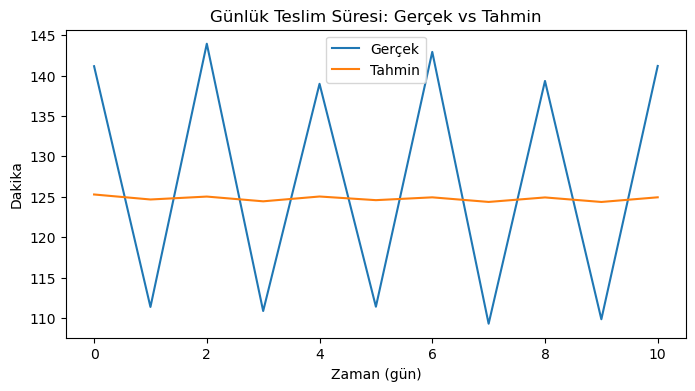

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_scaled = model.predict(X_test).ravel()

y_true = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"MAE: {mae:.2f}  |  RMSE: {rmse:.2f}")

plt.figure(figsize=(8,4))
plt.plot(y_true, label="Gerçek")
plt.plot(y_pred, label="Tahmin")
plt.title("Günlük Teslim Süresi: Gerçek vs Tahmin")
plt.xlabel("Zaman (gün)")
plt.ylabel("Dakika")
plt.legend()
plt.show()

In [79]:
df["order_dt"] = pd.to_datetime(df["Order_Date"] + " " + df["Order_Time"], errors="coerce")
df["hour"] = pd.to_datetime(df["Order_Time"], format="%H:%M:%S", errors="coerce").dt.hour
df["dow"]  = df["order_dt"].dt.dayofweek

cats = ["Weather","Traffic","Vehicle","Area","Category"]
dummies = pd.get_dummies(df[cats], prefix=cats)
tmp = pd.concat([df[["order_dt","Delivery_Time","Agent_Age","Agent_Rating","hour","dow"]], dummies], axis=1)

daily_feats = (tmp.set_index("order_dt")
                 .resample("D").mean()
                 .interpolate(limit_direction="both"))

y_series = daily_feats["Delivery_Time"].copy()
X_feats  = daily_feats.drop(columns=["Delivery_Time"])
print(X_feats.shape, "özellik, gün:", len(X_feats))

(55, 37) özellik, gün: 55


In [80]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

y_series = daily_feats["Delivery_Time"].values.reshape(-1,1)
X_feats  = daily_feats.drop(columns=["Delivery_Time"]).values

sc_y = MinMaxScaler(); y_scaled = sc_y.fit_transform(y_series).ravel()
sc_X = MinMaxScaler(); X_scaled = sc_X.fit_transform(X_feats)

SEQ_LEN = 14
def make_seq_mv(Xarr, yarr, L):
    Xs, ys = [], []
    for i in range(len(yarr)-L):
        Xs.append(Xarr[i:i+L, :])
        ys.append(yarr[i+L])
    return np.array(Xs, dtype="float32"), np.array(ys, dtype="float32")

split = int(len(y_scaled)*0.8)
X_tr, y_tr = make_seq_mv(X_scaled[:split], y_scaled[:split], SEQ_LEN)

X_test_full = np.vstack([X_scaled[split-SEQ_LEN:split], X_scaled[split:]])
y_test_full = np.hstack([y_scaled[split-SEQ_LEN:split], y_scaled[split:]])
X_te, y_te = make_seq_mv(X_test_full, y_test_full, SEQ_LEN)

print("Train:", X_tr.shape, y_tr.shape, " | Test:", X_te.shape, y_te.shape)

Train: (30, 14, 37) (30,)  | Test: (11, 14, 37) (11,)


Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.2160 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2465 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2331 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1976 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2005 - val_loss: 0.1495 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1890 - val_loss: 0.1526 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1906 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1819 - val_loss: 0.1421 - learning_rate: 0.0010
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1936 - val_loss: 0.1431 - learning_rate: 0.0010
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


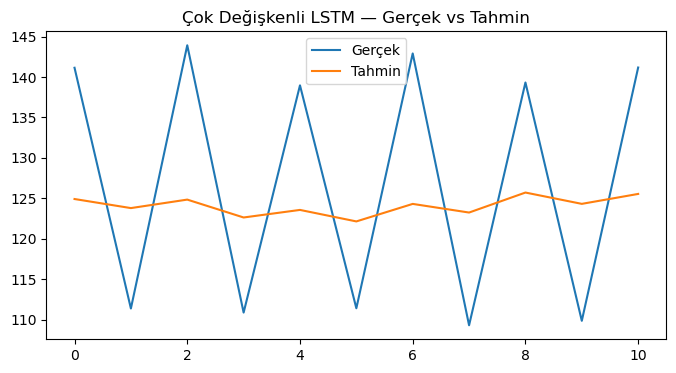

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

n_feats = X_tr.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, n_feats)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

es  = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_tr, y_tr, epochs=200, batch_size=16,
                    validation_split=0.2, callbacks=[es, rlr], verbose=1)

y_pred_s = model.predict(X_te).ravel()
y_true   = sc_y.inverse_transform(y_te.reshape(-1,1)).ravel()
y_pred   = sc_y.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")

plt.figure(figsize=(8,4))
plt.plot(y_true, label="Gerçek"); plt.plot(y_pred, label="Tahmin")
plt.title("Çok Değişkenli LSTM — Gerçek vs Tahmin")
plt.legend(); plt.show()

In [82]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true_s = y_te  # ölçekli
y_naive_s = X_te[:, -1, 0]  # hedefin kendisi 1. sütun ise 0; değilse Delivery_Time sütun indeksini kullan

y_true  = sc_y.inverse_transform(y_true_s.reshape(-1,1)).ravel()
y_naive = sc_y.inverse_transform(y_naive_s.reshape(-1,1)).ravel()

from sklearn.metrics import mean_absolute_error, mean_squared_error
naive_mae  = mean_absolute_error(y_true, y_naive)
naive_rmse = mean_squared_error(y_true, y_naive, squared=False)
print(f"Naive → MAE:{naive_mae:.2f} | RMSE:{naive_rmse:.2f}")

lstm_mae  = mean_absolute_error(y_true, y_pred)
lstm_rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"LSTM  → MAE:{lstm_mae:.2f} | RMSE:{lstm_rmse:.2f}")

Naive → MAE:14.30 | RMSE:16.14
LSTM  → MAE:14.72 | RMSE:14.94


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [83]:
horizon = 7
win = X_te[-1:].copy()      
feat_last = win[0, -1, :].copy() 

future_s = []
for _ in range(horizon):
    yhat = model.predict(win, verbose=0)[0,0]   
    future_s.append(yhat)
    new_step = feat_last.copy()                 
    win = np.concatenate([win[:,1:,:], new_step.reshape(1,1,-1)], axis=1)

future = sc_y.inverse_transform(np.array(future_s).reshape(-1,1)).ravel()
print("Multivariate forecast (dakika):", np.round(future, 2))

Multivariate forecast (dakika): [125.54 126.31 126.58 127.   127.08 126.94 127.  ]
